# Emotion recognition from tweets using Tensorflow
### by Diego Garrocho
---
## Project Outline
1. Intro
2. Set up
3. Importing data
4. Tokenization
5. Sequences
6. Labelling
7. Model creating
8. Model training 
9. Model deployment and eval

## 1. Intro
---
In our current age, the use of technology has turned into an essential part of the everyday life. Given the social aspect of human beings it is of no surprise that a huge part of the time spent on technological platforms on a daily basis is spent browsing social media. Through the use of social media it is possible to share opinions,ideas, pictures, etc. which usually convey feelings and emotions.
From a business perspective the understanding of said feelings and emotions could prove to be a useful tool for the analysis of the general sentiment to a specific product or event. One of the biggest social media platforms which is also mainly text focused is Twitter. Having this in mind, it also proves to be a great platform to acquire the required data to work with.
Through the utilization of machine learning tools such as Tensorflow it is possible to reach an understanding of large quantities of data without much effort and in a short period of time.

## 2. Set up
---


In [1]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 5.0 MB/s 
     |████████████████████████████████| 243 kB 42.1 MB/s 


In [33]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()
    
print('Tensorflow ver: ', tf.__version__)

Tensorflow ver:  2.6.0


## 3. Importing data
---
Importing dataset and creating test sets

In [3]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train = dataset['train']
validation = dataset['validation']
test = dataset['test']

In [6]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [7]:
tweets, labels = get_tweet(train)

In [8]:
tweets[0:3], labels[0:3]

(['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong'],
 ['sadness', 'sadness', 'anger'])

## 4. Tokenization
---
 Separating a piece of text into smaller units.

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words= 10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [11]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [12]:
#checking "translation"
tweets[0]

'i didnt feel humiliated'

## 5. Sequences
---
Understanding the difference in lenghts of tweets and shaping them in order for the model to work with them.

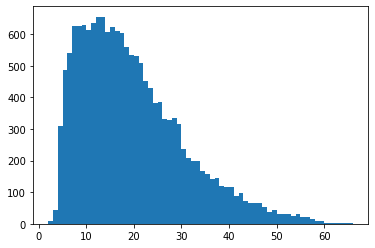

In [13]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded_sequences = pad_sequences(sequences, truncating='post', padding='post', maxlen=50)
  return padded_sequences

In [16]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [17]:
#Checking if the padding works
padded_train_seq[1]

array([   2,   40,  101,   60,    8,   15,  494,    5,   15, 3496,  553,
         32,   60,   61,  128,  148,   76, 1480,    4,   22, 1255,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

## 6. Labelling
---


In [18]:
classes = set(labels)
print(classes)

{'anger', 'love', 'sadness', 'fear', 'surprise', 'joy'}


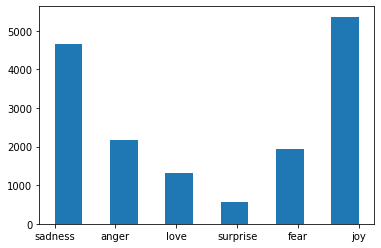

In [19]:
plt.hist(labels, bins= 11)
plt.show()

In [20]:
class_to_index = dict((c, i) for i , c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [21]:
class_to_index

{'anger': 0, 'fear': 3, 'joy': 5, 'love': 1, 'sadness': 2, 'surprise': 4}

In [22]:
index_to_class

{0: 'anger', 1: 'love', 2: 'sadness', 3: 'fear', 4: 'surprise', 5: 'joy'}

In [23]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [24]:
 train_labels = names_to_ids(labels)
#Cheching if labels work correctly
 print(train_labels[0])

2


## 7. Model Creating
---
Creation and compiling

In [25]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=50),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation = 'softmax')                            
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## 8. Model Training
---
Using a validation set and then training the model.

In [27]:
val_tweets, val_labels = get_tweet(validation)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [28]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [29]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 38s 56ms/step - loss: 1.3428 - accuracy: 0.4508 - val_loss: 0.8418 - val_accuracy: 0.6780
Epoch 2/20
500/500 [==============================] - 27s 53ms/step - loss: 0.6466 - accuracy: 0.7655 - val_loss: 0.6346 - val_accuracy: 0.7855
Epoch 3/20
500/500 [==============================] - 27s 54ms/step - loss: 0.4203 - accuracy: 0.8556 - val_loss: 0.6811 - val_accuracy: 0.7840
Epoch 4/20
500/500 [==============================] - 26s 52ms/step - loss: 0.3042 - accuracy: 0.8994 - val_loss: 0.4781 - val_accuracy: 0.8460
Epoch 5/20
500/500 [==============================] - 27s 53ms/step - loss: 0.2097 - accuracy: 0.9358 - val_loss: 0.4423 - val_accuracy: 0.8610
Epoch 6/20
500/500 [==============================] - 27s 53ms/step - loss: 0.1559 - accuracy: 0.9528 - val_loss: 0.4666 - val_accuracy: 0.8655
Epoch 7/20
500/500 [==============================] - 26s 53ms/step - loss: 0.1220 - accuracy: 0.9625 - val_loss: 0.4632 - val_accuracy:

## 9. Model deployment and eval
---
Looking at the training history, prepping a test set and observing results.

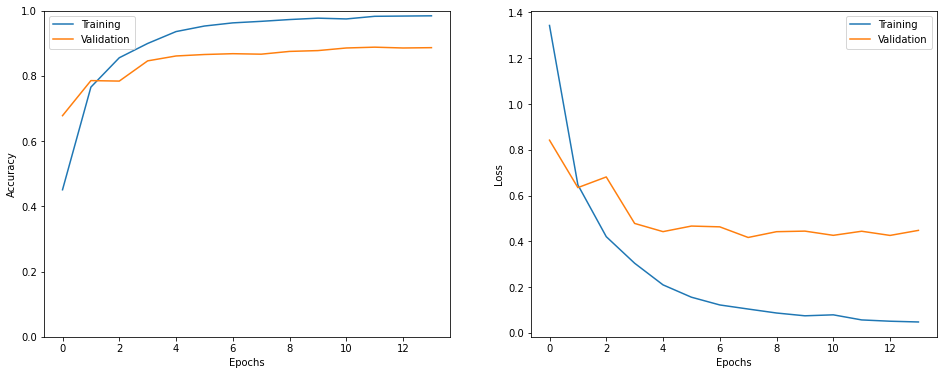

In [34]:
show_history(h)

In [41]:
test_tweets, test_labels = get_tweet(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [42]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 19ms/step - loss: 0.4465 - accuracy: 0.8930


In [52]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence: ', test_tweets[i])
print('Emotion: ', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion: ', pred_class)

Sentence:  i don t know if this helps at all but writing all of this has made me feel somewhat regretful of ashamed of who i was and while i have more to share i just don t think i can right now
Emotion:  sadness
Predicted Emotion:  sadness


In [59]:
preds = model.predict(test_seq)

preds = np.argmax(preds, axis=1)

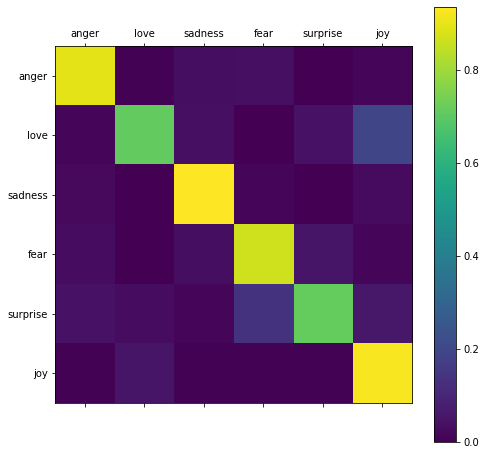

In [60]:
show_confusion_matrix(test_labels, preds, list(classes))